In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import re
import time
import wandb
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
import logging
from datetime import datetime, timedelta
import sys
from PIL import Image

In [2]:
# Constants
OUTPUT_FOLDER = 'C:\\Users\\stjoh\\Documents\\ActiveInference\\Sophisticated-Learning'
POLLING_INTERVAL = 600  # Time in seconds between checks for new files
FILE_PATTERN = re.compile(r"(\d{2}-\d{2}-\d{2}-\d{3})_seed_(\d+)_([A-Z]+)_experiment.txt")

def load_data(file_path):
    """Loads numerical data from a given file."""
    with open(file_path, 'r') as file:
        data = [float(line.strip()) for line in file.readlines() if line.strip()]
    return data

def get_latest_files(directory):
    """Finds the latest files for each algorithm-seed combination."""
    files = {}
    for file_name in os.listdir(directory):
        match = FILE_PATTERN.match(file_name)
        if match:
            timestamp, seed, algorithm = match.groups()
            key = (seed, algorithm)
            if key not in files or timestamp > files[key][0]:
                files[key] = (timestamp, os.path.join(directory, file_name))
    return [info[1] for info in files.values()]

In [3]:
def plot_regression(ax, x_data, y_data, algorithm):
    """Plots different types of regression models on given axes."""
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline

    # Linear Regression
    lin_model = LinearRegression()
    lin_model.fit(x_data[:, np.newaxis], y_data)
    y_lin_pred = lin_model.predict(x_data[:, np.newaxis])
    coef_lin = lin_model.coef_[0]
    intercept_lin = lin_model.intercept_
    lin_label = f'Linear: $y = {intercept_lin:.2f} + {coef_lin:.2f}x$'
    ax.plot(x_data, y_lin_pred, label=lin_label, color='blue')

    # Polynomial Regression (Degree 2)
    poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
    poly_model.fit(x_data[:, np.newaxis], y_data)
    y_poly_pred = poly_model.predict(x_data[:, np.newaxis])
    coef_poly = poly_model.named_steps['linearregression'].coef_
    intercept_poly = poly_model.named_steps['linearregression'].intercept_
    
    # Correctly access the coefficients; note that coef_poly[0] is for the bias term added by PolynomialFeatures
    poly_label = f'Polynomial: $y = {intercept_poly:.2f} + {coef_poly[1]:.2f}x {coef_poly[2]:.3f}x^2$'
    ax.plot(x_data, y_poly_pred, label=poly_label, color='green')

    ax.scatter(x_data, y_data, color='red', s=10)  # Plot data points
    ax.set_title(f'Performance Over Time: {algorithm}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Survival Time')
    
    lin_eq = f'Linear equation: y = {intercept_lin} + {coef_lin}x'
    poly_eq = f'Polynomial equation: y = {intercept_poly} + {coef_poly[1]}x + {coef_poly[2]}x^2'
    logging.info(f"{algorithm} - {lin_eq}")
    logging.info(f"{algorithm} - {poly_eq}")

    ax.legend()
    plt.show()

In [7]:
def cohens_d(group1, group2):
    """Compute Cohen's d for independent samples."""
    diff = group1.mean() - group2.mean()
    pooled_sd = np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)
    return diff / pooled_sd

def perform_analyses(data_df):
    """Enhanced analysis including interactions and post-hoc tests."""
    logging.info("Starting mixed-effects model analysis...")
    
    from statsmodels.formula.api import mixedlm
    import statsmodels.api as sm

    # Mixed effects model with interaction between Algorithm and Trial
    model = mixedlm("SurvivalTime ~ C(Algorithm, Treatment(reference='SI')) * Trial", data_df, groups=data_df["Seed"])
    result = model.fit()
    logging.info(f"Linear Mixed Effects Model results:\n{result.summary()}")

    # Extracting the model summary to log or display
    model_summary = result.summary()
    logging.info(model_summary)

    # Correct import for the pairwise Tukey HSD test
    from statsmodels.stats.multicomp import pairwise_tukeyhsd

    # Post-hoc analysis using pairwise comparisons
    tukey = pairwise_tukeyhsd(endog=data_df['SurvivalTime'], groups=data_df['Algorithm'], alpha=0.05)
    logging.info(f"Tukey HSD results:\n{tukey.summary()}")

def gather_and_analyze_data():
    """Function to gather data, perform statistical analysis, and plot results."""
    data_dict = {}
    files = get_latest_files(OUTPUT_FOLDER)
    for file_path in files:
        details = FILE_PATTERN.search(os.path.basename(file_path)).groups()
        _, seed, algorithm = details
        data = load_data(file_path)
        if algorithm not in data_dict:
            data_dict[algorithm] = {}
        if seed not in data_dict[algorithm]:
            data_dict[algorithm][seed] = []
        data_dict[algorithm][seed].extend(data)

    df_list = []
    for algorithm, seeds in data_dict.items():
        for seed, values in seeds.items():
            trials_df = pd.DataFrame({'SurvivalTime': values})
            trials_df['Trial'] = trials_df.index
            trials_df['Algorithm'] = algorithm
            trials_df['Seed'] = seed
            df_list.append(trials_df)
    data_df = pd.concat(df_list)

    perform_analyses(data_df)
    return data_df

In [8]:
def plot_violin(data_df):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # Create two subplots vertically

    # Plot for all data
    sns.violinplot(x='Algorithm', y='SurvivalTime', data=data_df, ax=axs[0])
    axs[0].set_title("Survival Time Distribution by Algorithm")
    axs[0].set_xlabel("Algorithm")
    axs[0].set_ylabel("Survival Time")

    # Filtering data to remove early deaths (SurvivalTime <= 25)
    filtered_data = data_df[data_df['SurvivalTime'] > 25]

    # Plot for filtered data
    sns.violinplot(x='Algorithm', y='SurvivalTime', data=filtered_data, ax=axs[1])
    axs[1].set_title("Survival Time Distribution by Algorithm (Excluding Survival Time <= 25)")
    axs[1].set_xlabel("Algorithm")
    axs[1].set_ylabel("Survival Time")       


In [11]:
data_df = gather_and_analyze_data()  

<Axes: title={'center': 'Average Survival Time vs. Trial (SI)'}, xlabel='Trial', ylabel='Average Survival Time'>

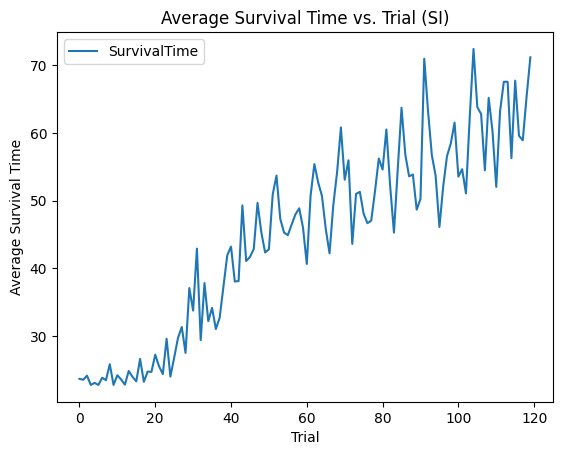

In [32]:
# Average over seeds for SI algorithm to show average survival vs trial
# Plot each algorithm on same axes in different colours
data_df[data_df['Algorithm'] == 'SI'].select_dtypes(include=[np.number]).groupby('Trial').mean().plot(y='SurvivalTime', title='Average Survival Time vs. Trial (SI)', xlabel='Trial', ylabel='Average Survival Time')
    

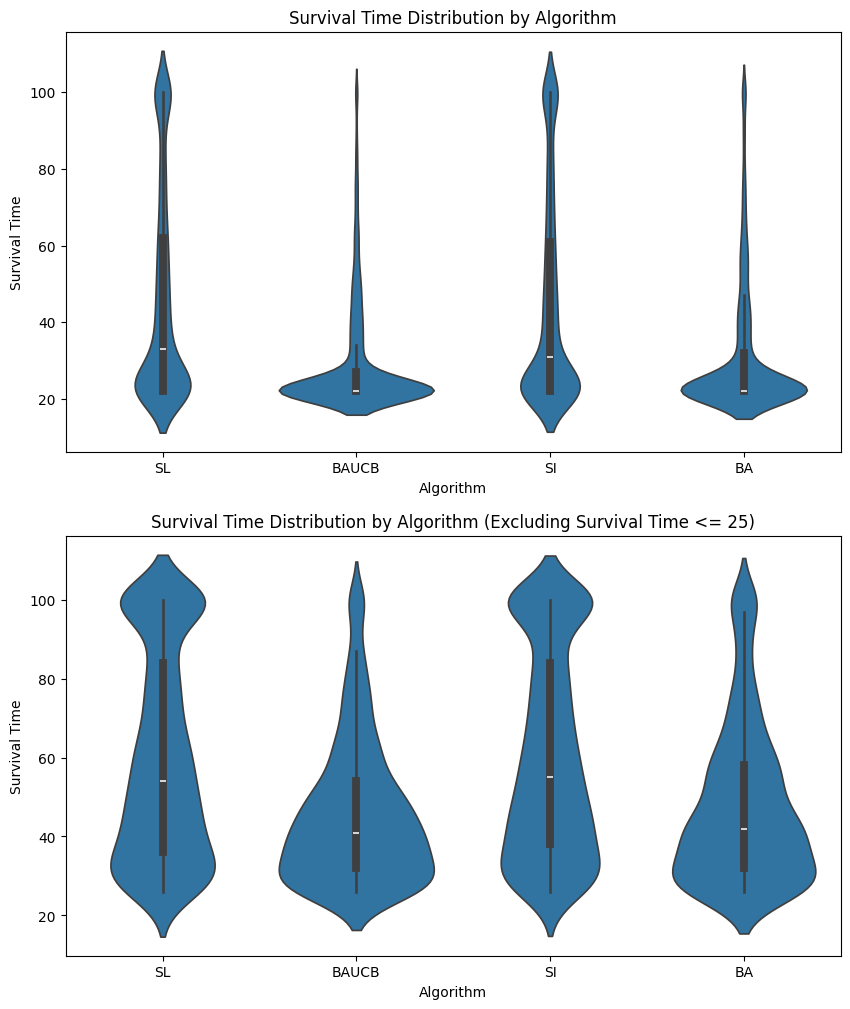

In [31]:
plot_violin(data_df)

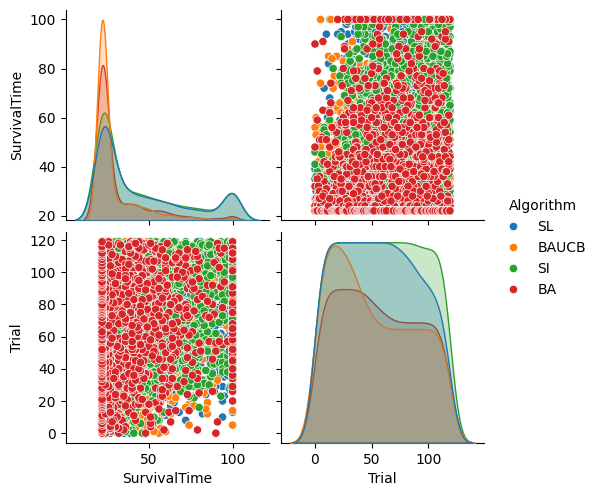

In [33]:
# EDA on the data
sns.pairplot(data_df, hue='Algorithm')

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

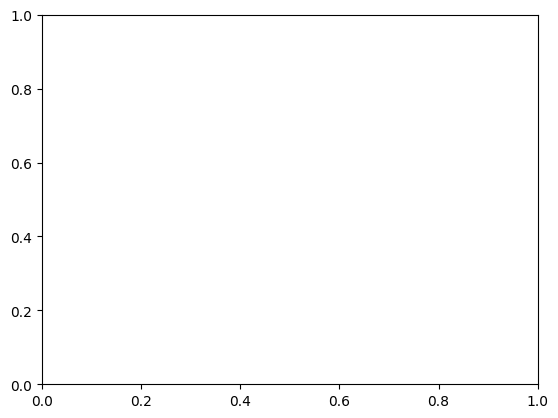

In [36]:
plot_regression(plt.gca(), data_df['Trial'], data_df['SurvivalTime'], 'SI')